In [98]:
# %%
# %   COURSE: Neural signal processing and analysis: Zero to hero
# %  SESSION: Time-frequency analysis: Problem set
# %  TEACHER: Mike X Cohen, sincxpress.com
# %

# # 

In [205]:
import sys
sys.path.insert(1, '../')
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import cmath
from scipy.io import loadmat
from scipy.signal import firwin, filtfilt, hilbert
from numpy.fft import fft, ifft
import random
import matplotlib as mpl
from attributedict.collections import AttributeDict



mpl.rcParams['figure.figsize'] = (12, 6) 
pi = np.pi

In [100]:
# %% 1) Power and phase from the famous "trial 10"
# %    Create a family of complex Morlet wavelets that range from 10 Hz to 100 Hz in 43 linearly spaced steps. 
# %    Perform convolution between the wavelets and V1 data from trial 10 for all channels.
# %    Extract power and phase, store the results in a channel X frequency X time X pow/phs (thus, 4D) matrix.


In [101]:
laminar = loadmat("../v1_laminar.mat")
csd = laminar['csd']
timevec = np.squeeze(laminar['timevec'].T)
srate = laminar['srate'].item()


In [102]:
# % soft-coded parameters
freqrange  = [10, 100] # extract only these frequencies (in Hz)
numfrex    = 43       # number of frequencies between lowest and highest
whichTrial = 9

data = csd[:,:,whichTrial]


# % set up convolution parameters
wavtime = np.arange(-2,2-1/srate,1/srate)
frex    = np.linspace(freqrange[0],freqrange[1],numfrex)
nData   = len(timevec);
nKern   = len(wavtime);
nConv   = nData + nKern - 1;
halfwav = (len(wavtime)-1)//2;

# % number of cycles
numcyc = np.linspace(3,15,numfrex);

# create wavelets
cmwX = np.zeros((numfrex, nConv), dtype=complex)
for fi in range(numfrex):
    
    # create time-domain wavelet
    s = numcyc[fi] / (2*pi*frex[fi])
    twoSsquared = (2*s) ** 2
    cmw = np.exp(2*1j*pi*frex[fi]*wavtime) * np.exp( (-wavtime**2) / twoSsquared )

    
    # compute fourier coefficients of wavelet and normalize
    cmwX[fi, :] = fft(cmw, nConv)
    cmwX[fi, :] = cmwX[fi, :] / max(cmwX[fi, :])
    
    
# % initialize time-frequency output matrix
tf = np.zeros((data.shape[0], numfrex, len(timevec), 2))

# % loop over channels
for chani in range(data.shape[0]):
    
#     % compute Fourier coefficients of EEG data (doesn't change over frequency!)
    eegX = fft(data[chani,:] , nConv)
    
#     % loop over frequencies
    for fi in range(numfrex):
        
#         % second and third steps of convolution
        as_ = ifft( cmwX[fi,:]*eegX)
        
#         % cut wavelet back to size of data
        as_ = as_[halfwav: -halfwav]
            
#        extract power 
        tf[chani, fi, :, 0] = abs(as_) ** 2
    
        # extract phase
        tf[chani, fi, :, 1] = np.angle(as_)
        

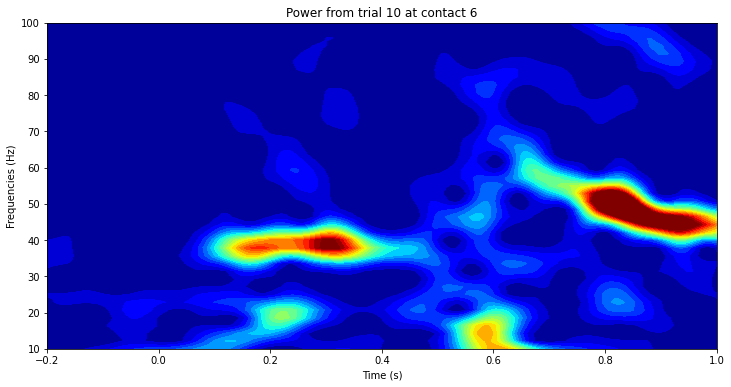

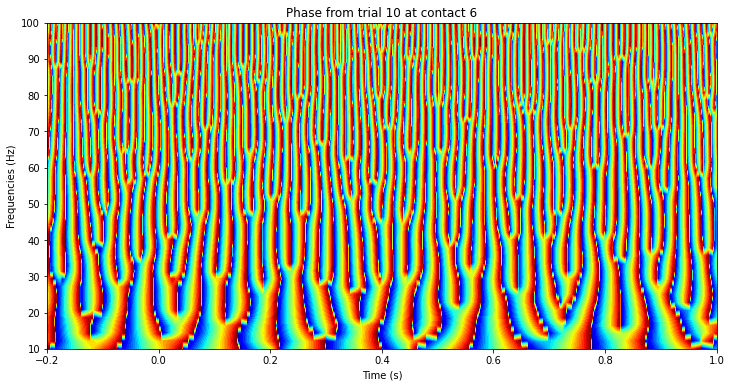

In [103]:
# %% plotting the results, part 1: time-frequency
# % In a 1x2 subplot figure, plot time-frequency power (left) and phase (right) from electrode 6.
# % use x-axis scaling of -200 to +1000 ms.

chan2plot = 5;

plt.contourf(timevec,frex, tf[chan2plot,:,:,0], 40, cmap='jet', vmin=0, vmax=80000)
plt.xlabel('Time (s)')
plt.ylabel('Frequencies (Hz)')
plt.title( f'Power from trial {whichTrial+1} at contact {chan2plot+1}')
plt.xlim([-0.2,1])
plt.show()


plt.contourf(timevec,frex, tf[chan2plot,:,:,1],40, cmap='jet', vmin=-pi, vmax=pi)
plt.xlabel('Time (s)')
plt.ylabel('Frequencies (Hz)')
plt.title( f'Phase from trial {whichTrial+1} at contact {chan2plot+1}')
plt.xlim([-0.2,1])
plt.show()

In [104]:
tf[:, hzsInds[i], :, 0 ].shape, timevec.shape, csd.shape[0]

((16, 1527), (1527,), 16)

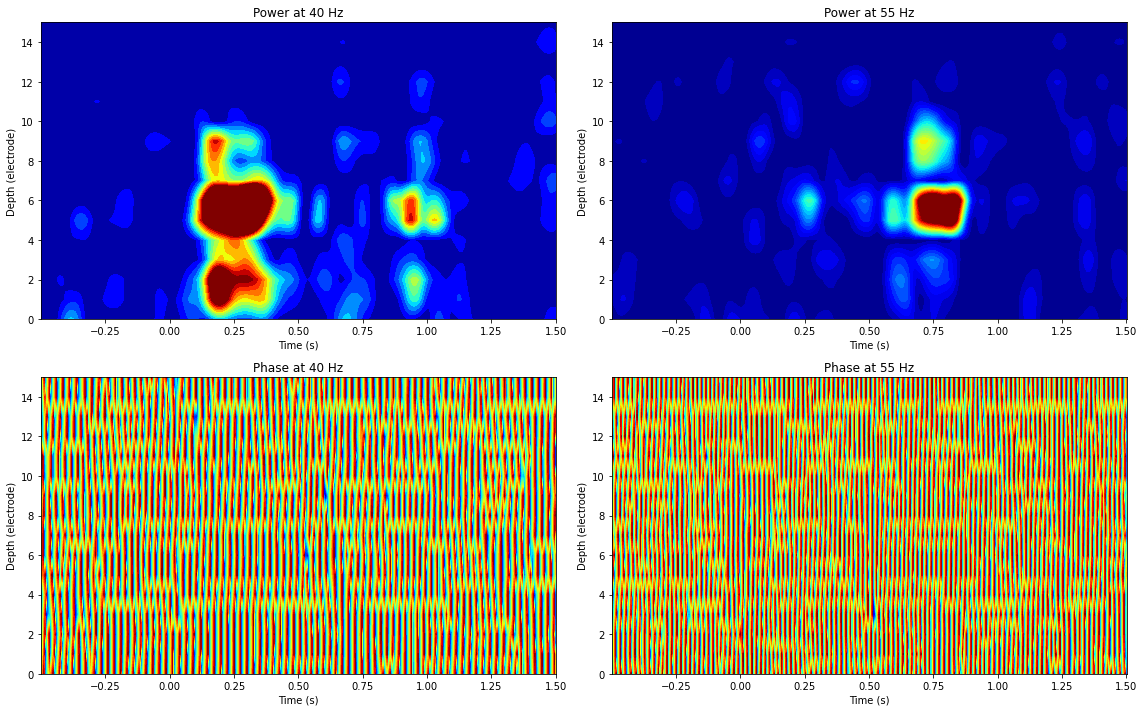

In [110]:
hzs = [40, 55]
hzsInds = [0,0]
hzsInds[0] = np.argmin(abs(frex - hzs[0]))
hzsInds[1] = np.argmin(abs(frex - hzs[1]))

fig, axs = plt.subplots(2,2, figsize=(16,10))

for i in range(2):
    
    axs[0, i].contourf(timevec, np.arange(csd.shape[0]), tf[:, hzsInds[i], :, 0 ], 40, vmin=0, vmax=40000, cmap='jet');
    axs[0, i].set_title(f'Power at {hzs[i]} Hz' )
    axs[0, i].set_xlabel('Time (s)')
    axs[0, i].set_ylabel('Depth (electrode)')
    
    axs[1, i].contourf(timevec, np.arange(csd.shape[0]), tf[:, hzsInds[i], :, 1 ], 40, vmin=-pi, vmax=pi, cmap='jet');
    axs[1, i].set_title(f'Phase at {hzs[i]} Hz' )
    axs[1, i].set_xlabel('Time (s)')
    axs[1, i].set_ylabel('Depth (electrode)')
plt.tight_layout()
plt.show()

In [112]:
# %% 2) Convolution with all trials
# %    Repeat the previous exercise, but using data from all trials. Don't save the single-trial data.
# %    Instead of the raw phases, compute ITPC. 
# %    Generate the same plots as in #2.

# %%% QUESTION: Which parameters/variables do you need to recompute, 
# %             and which can you reuse from above?


In [140]:
data = np.reshape(csd, (csd.shape[0], csd.shape[1]*csd.shape[2]), order='F')

# % set up convolution parameters
nData   = data.shape[1];
nConv   = nData + nKern - 1;

# % number of cycles
numcyc = np.linspace(3,15,numfrex);

# create wavelets
cmwX = np.zeros((numfrex, nConv), dtype=complex)
for fi in range(numfrex):
    
    # create time-domain wavelet
    s = numcyc[fi] / (2*pi*frex[fi])
    twoSsquared = (2*s) ** 2
    cmw = np.exp(2*1j*pi*frex[fi]*wavtime) * np.exp( (-wavtime**2) / twoSsquared )

    
    # compute fourier coefficients of wavelet and normalize
    cmwX[fi, :] = fft(cmw, nConv)
    cmwX[fi, :] = cmwX[fi, :] / max(cmwX[fi, :])
    
    
# % initialize time-frequency output matrix
tf = np.zeros((data.shape[0], numfrex, len(timevec), 2))

# % loop over channels
for chani in range(data.shape[0]):
    
#     % compute Fourier coefficients of EEG data (doesn't change over frequency!)
    eegX = fft(data[chani,:] , nConv)
    
#     % loop over frequencies
    for fi in range(numfrex):
        
#         % second and third steps of convolution
        as_ = ifft( cmwX[fi,:] * eegX)
        
#         % cut wavelet back to size of data
        as_ = as_[halfwav: -halfwav]
        as_ = np.reshape(as_, (csd.shape[1], csd.shape[2]), order='F')
            
#        extract power 
        tf[chani, fi, :, 0] = np.mean(abs(as_) ** 2, axis=1)
    
        # extract phase
        tf[chani, fi, :, 1] = abs(np.mean(np.exp(1j*np.angle(as_)), axis=1))
        

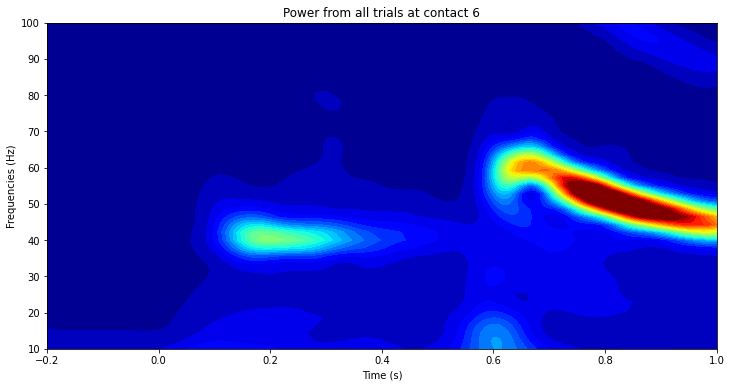

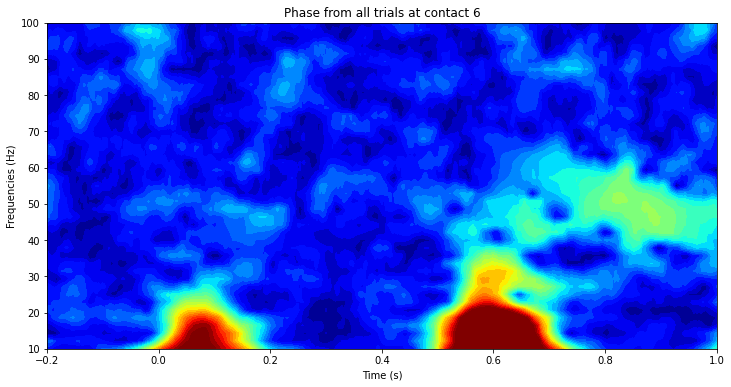

In [142]:
plt.contourf(timevec,frex, tf[chan2plot,:,:,0], 40, cmap='jet', vmin=0, vmax=80000)
plt.xlabel('Time (s)')
plt.ylabel('Frequencies (Hz)')
plt.title( f'Power from all trials at contact {chan2plot+1}')
plt.xlim([-0.2,1])
plt.show()


plt.contourf(timevec,frex, tf[chan2plot,:,:,1],40, cmap='jet', vmin=0, vmax=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Frequencies (Hz)')
plt.title( f'Phase from all trials at contact {chan2plot+1}')
plt.xlim([-0.2,1])
plt.show()

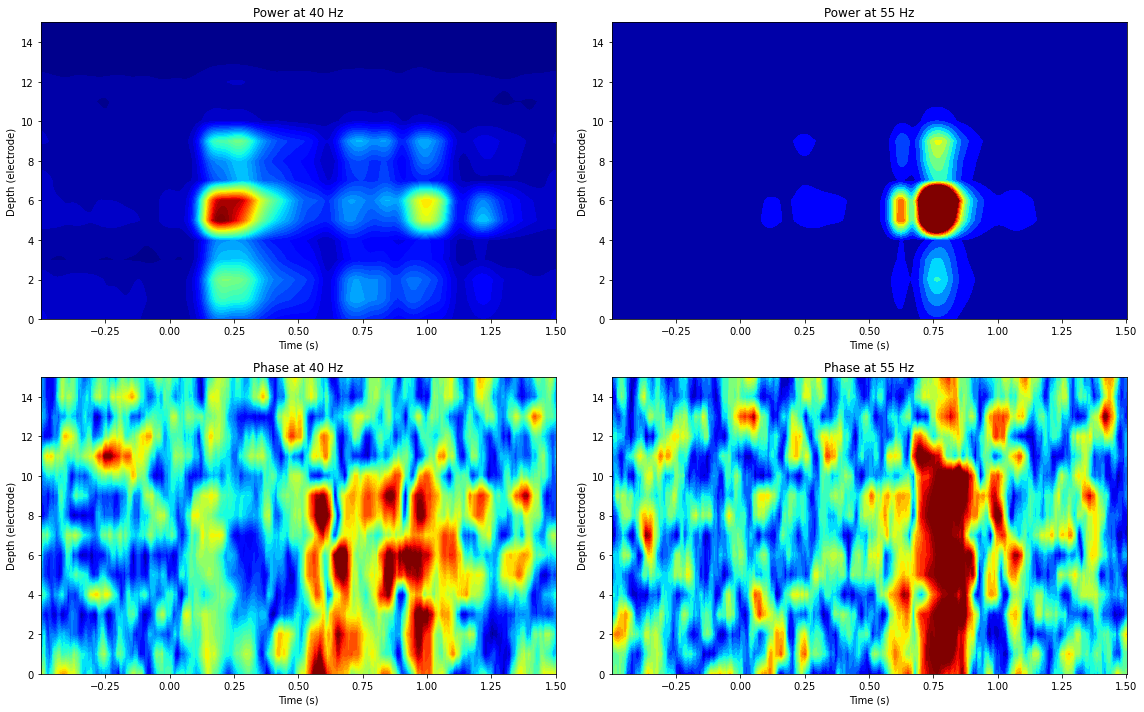

In [144]:
fig, axs = plt.subplots(2,2, figsize=(16,10))

for i in range(2):
    
    axs[0, i].contourf(timevec, np.arange(csd.shape[0]), tf[:, hzsInds[i], :, 0 ], 40, vmin=0, vmax=40000, cmap='jet');
    axs[0, i].set_title(f'Power at {hzs[i]} Hz' )
    axs[0, i].set_xlabel('Time (s)')
    axs[0, i].set_ylabel('Depth (electrode)')
    
    axs[1, i].contourf(timevec, np.arange(csd.shape[0]), tf[:, hzsInds[i], :, 1 ], 40, vmin=0, vmax=0.2, cmap='jet');
    axs[1, i].set_title(f'Phase at {hzs[i]} Hz' )
    axs[1, i].set_xlabel('Time (s)')
    axs[1, i].set_ylabel('Depth (electrode)')
plt.tight_layout()
plt.show()

In [145]:
# %% 2) Exploring edge effects
# %    Create a square-wave time series and perform a time-frequency
# %    analysis, in order to explore the effects of edges on TF responses.

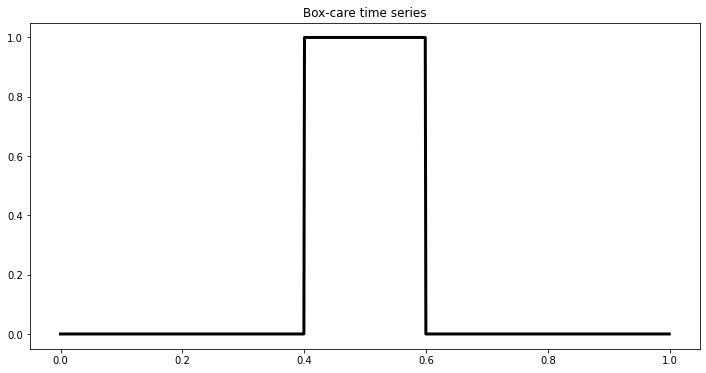

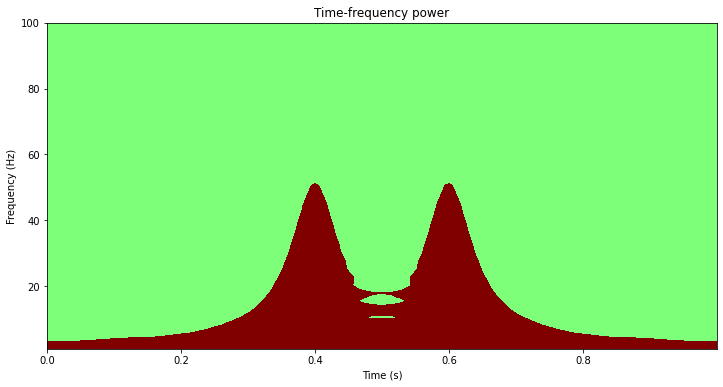

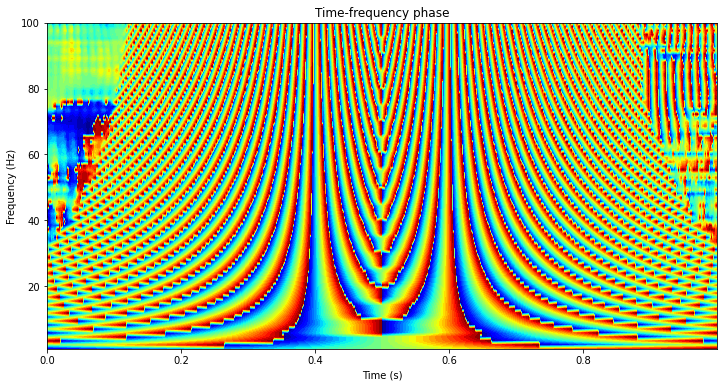

In [179]:
srate = 999;
npnts = srate*1
time  = np.arange(npnts)/srate

# % create the square wave function
squarets = np.zeros((npnts))
squarets[ round(npnts*.4) : round(npnts*.6) ] = 1

# % plot it

plt.plot(time,squarets, 'k', linewidth=3)
plt.title('Box-care time series')
plt.show()
# %% time-frequency analysis

# % soft-coded parameters
freqrange  = [1, 100];#% extract only these frequencies (in Hz)
numfrex    = 83      # number of frequencies between lowest and highest


# % set up convolution parameters
wavtime = np.arange(-2,2,1/srate)
frex    = np.linspace(freqrange[0],freqrange[1],numfrex)
nKern   = len(wavtime);
nConv   = nKern + npnts - 1;
halfwav = (len(wavtime)-1)//2;

# % number of cycles
numcyc = np.linspace(3,15,numfrex); # (hmmm)


# % compute Fourier coefficients of signal
impfunX = fft(squarets ,nConv);


# % initialize TF matrix
tf = np.zeros((numfrex,npnts, 2));

for fi in range(numfrex):
    
    # create time-domain wavelet
    s = numcyc[fi] / (2*pi*frex[fi])
    twoSsquared = (2*s) ** 2
    cmw = np.exp(2*1j*pi*frex[fi]*wavtime) * np.exp( (-wavtime**2) / twoSsquared )
    
    cmwX = fft(cmw, nConv)
    cmwX = cmwX / max(cmwX)
    
    as_ = ifft(cmwX * impfunX)
    as_ = as_[halfwav+1:-halfwav]
    # extract power and phase
    tf[fi, :, 0] = abs(as_) ** 2
    tf[fi, :, 1] = np.angle(as_)
    
plt.contourf(time,frex, tf[:,:,0],40, vmin=0, vmax=0.001, cmap='jet')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Time-frequency power')
plt.show()

plt.contourf(time,frex, tf[:,:,1],40, cmap='jet')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Time-frequency phase')
plt.show()

# %%% QUESTION: How "bad" is it? 
# %             Does the edge more adversely affect power or phase?
# % 
# % 
# %%% QUESTION: What would you consider a reasonable "buffer" in terms of
# %             cycles per frequency to avoid the edge effects?
# % 
# % 
# %%% QUESTION: Does the size of the edge effect depend on the amplitude of
# %             the box?
# % 
# % 
# %%% QUESTION: Does it also depend on the number of cycles for the wavelet?
# % 
# % 

In [180]:
# %% 3) Improving the spectral precision of wavelet convolution.

# % Remember from the first section of the course that we identified a "failure scenario" 
# % in which wavelet convolution failed to identify two sine waves that were simulated and 
# % clearly visible in the static spectrum. Let's revisit that example.

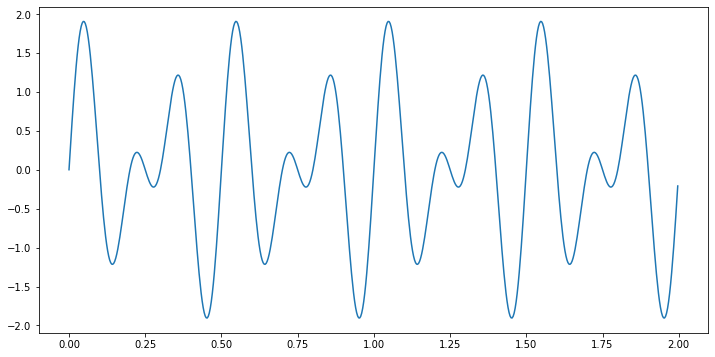

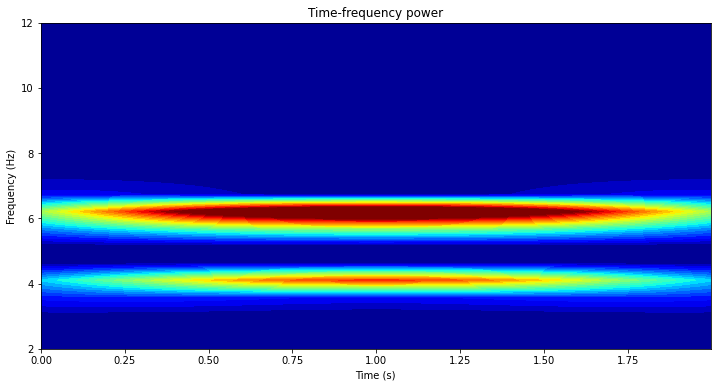

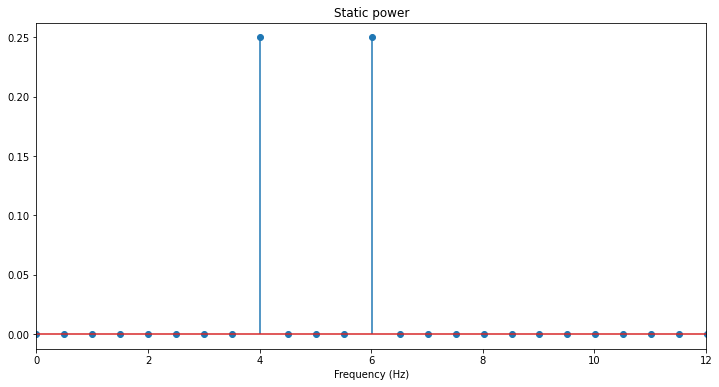

In [246]:
srate = 300;
time = np.arange(srate*2)/srate;

# % create the signal with 4 and 6 Hz components
signal = np.sin(2*pi*4*time) + np.sin(2*pi*6*time);


# % compute static power spectrum
powr = abs(fft(signal)/len(time))**2;
hz = np.linspace(0,srate,len(time));


# % soft-coded parameters
freqrange  = [2, 12];#% extract only these frequencies (in Hz)
numfrex    = 20      # number of frequencies between lowest and highest


# % set up convolution parameters
wavtime = np.arange(-2,2,1/srate)
frex    = np.linspace(freqrange[0],freqrange[1],numfrex)
nKern   = len(wavtime);
nConv   = nKern + len(time) - 1;
halfwav = (len(wavtime)-1)//2;

# % number of cycles
fwhms = np.linspace(2, 1, numfrex)
impfunX = fft(signal, nConv)
tf = np.zeros((numfrex, len(signal)))


for fi in range(numfrex):
    cmw = np.exp(2*1j*pi*frex[fi]*wavtime) * np.exp(-4*np.log(2)*wavtime**2 / fwhms[fi]**2)
    cmwX = fft(cmw, nConv)
    cmwX = cmwX / max(cmwX)
    
    as_ = ifft(impfunX * cmwX)
    as_ = as_[halfwav+1:-halfwav]
    tf[fi, :] = abs(as_) ** 2
    
plt.plot(time,signal)
plt.show()
# % plot time-frequency plot
plt.contourf(time,frex,tf,40,cmap='jet', vmin=0,vmax=0.2)
plt.title('Time-frequency power')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.show()

# % plot static power spectrum
plt.stem(hz,powr)
plt.xlim([0, freqrange[1]])
plt.title('Static power')
plt.xlabel('Frequency (Hz)')
plt.show()


# %%% QUESTION: Is time-frequency analysis completely utterly worthless?!!?
# % 
# % 
# %%% QUESTION: Try changing the FWHM limits to see if you can recover the
# %             signals. Can you get it better? Can you get it perfect?

In [202]:
# %% 4) Compare complex wavelet convolution with filter-Hilbert.

# % The goal here is to illustrate that complex Morlet wavelet convolution
# % can give the same or different results as filter-Hilbert, depending on parameters.
# % 

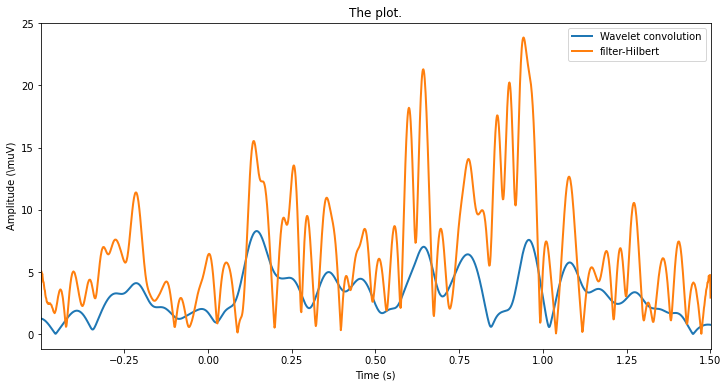

In [240]:
erp = np.mean(csd[6,:,:], axis=1)
# %% wavelet convolution

# % initial parameters and time vector
fwhm = .2; # seconds
wavetime = np.arange(2*srate)/srate;
wavetime = wavetime - np.mean(wavetime);
halfwave = len(wavetime)//2;

# % compute convolution N's
nConv = len(timevec) + len(wavetime) - 1;

# % create wavelet and compute its spectrum
cmw = np.exp( 1j*2*pi*42*wavetime ) * np.exp( -4*np.log(2)*wavetime**2 / fwhm**2 );
cmwX = fft(cmw,nConv);
cmwX = cmwX / max(cmwX)

erpX = fft(erp, nConv)

# % run convolution (multiplication of two spectra!!)
as_ = ifft( erpX * cmwX );
as_ = as_[halfwave:-halfwave+1];

cmw_amp = 2* abs(as_);

# %% Create an FIR filter at 42 Hz

# % create filter parameters
filter_width = 7; # ONE-SIDED hz
center_freq = 42;

# % fir1 parameters
fbounds = np.array([ center_freq-filter_width, center_freq+filter_width ]) / (srate/2);
order = 300;

# % create the filter kernel
filtkern = firwin(order+1,fbounds,pass_zero='bandpass');

# % apply the filter
filtsig = filtfilt(filtkern,[1],erp);

# % extract amplitude time series using hilbert
fh_amp = np.abs(hilbert(filtsig));

# figure(7), clf
plt.plot(timevec, cmw_amp, linewidth=2, label='Wavelet convolution')
plt.plot(timevec, fh_amp,linewidth=2, label='filter-Hilbert')

plt.xlim(timevec[[1 ,-1]])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (\muV)')
plt.title('The plot.')
plt.show()

# %%% TO DO: Based on visual inspection, modify the FIR parameters to make
# %          the two results as close as possible.
# % 

In [247]:
# %% 6) compare wavelet convolution and mean over time with static FFT

# % Adjust the code from the previous exercise to save the static spectrum
# %  without baseline normalization.
# % Then implement a static FFT (like what you learned in the previous
# %  section of the course) to get power from one electrode.
# % Compare the static power spectrum and the time-averaged TF power spectrum
# % on the same graph.